## 학습목표

- 데이터 사이언스 관련 최대 커뮤니티인 캐글의 경진대회에 직접 참여해서 문제를 해결해본다.
- 캐글에서 데이터를 내려받는 것으로부터 시작해서, 로컬 서버에서 자유롭게 다루어보며 문제 해결을 위한 고민을 해본다.
- 앙상블 기법의 개념과 강점을 이해하고, 여러 모델의 예측 결과를 Averaging 한 최종 결과로 캐글에 제출해본다.
- 하이퍼 파라미터 튜닝의 필요성과 의미를 이해하고, Grid Search, Random Search 등의 기법을 알아본다.
- Grid Search 기법을 활용해서 직접 하이퍼 파라미터 튜닝 실험을 해보고, 모델의 성능을 최대한 끌어올려본다.

## 학습목표

- 정형 데이터를 활용해 EDA와 간단한 분류, 회귀 문제를 해결해본 적이 있다.
- numpy, pandas, matplotlib을 활용해 정형 데이터를 자유자재로 다룰 수 있다.
- 정형 데이터를 활용해 다양한 모델을 학습시켜보고, 예측 결과를 도출하는 것까지의 과정을 코드로 진행할 수 있다.

# 라이브러리 설치

In [1]:
pip install -U xgboost

     |████████████████████████████████| 166.7 MB 17 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [2]:
pip install -U lightgbm

     |████████████████████████████████| 2.0 MB 4.2 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [3]:
pip install -U missingno

In [4]:
pip install -U scikit-learn

     |████████████████████████████████| 22.3 MB 1.5 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


# 시작

## 모듈 가져오기

In [5]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

print('done')

done


## 데이터 가져오기

In [6]:
data_dir = '/content/drive/MyDrive/Colab/kakr/data'

train_data_path = join(data_dir, 'train.csv')   # 훈련 데이터 경로
test_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

print(train_data_path)
print(test_data_path)


/content/drive/MyDrive/Colab/kakr/data/train.csv
/content/drive/MyDrive/Colab/kakr/data/test.csv


In [7]:
# 데이터 불러오기

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
print('train data dim : {}'.format(train.shape))
print('test data dim : {}'.format(test.shape))

train data dim : (15035, 21)
test data dim : (6468, 20)


## 데이터 살펴보기

In [8]:
# 전체 데이터의 자료형 확인

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [9]:
# 문자열인 트레인과 테스트의 date 컬럼을 정수형으로 정리

train['date'] = train['date'].apply(lambda i: i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i: i[:6]).astype(int)

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


[참고 링크](https://rstudio-pubs-static.s3.amazonaws.com/155304_cc51f448116744069664b35e7762999f.html)

**20140521부터 20150514 까지의 부동산 거래 데이터**

>1. id : Unique ID for each home sold \\
id : 집을 구분하는 번호
>>따로 저장 후 삭제

>2. date : Date of the home sale \\
date : 거래 된 날짜
>>월까지 자른 후 정수로 고치면 사용할 수 있을 것 같다

>3. price : Price of each home sold \\
price : 타겟 변수인 집의 가격
>>따로 분리 해둠

>4. bedrooms : Number of bedrooms \\
bedrooms : 침실의 수
>>범주형

>5. bathrooms : Number of bathrooms, where .5 accounts for a room with a toilet but no shower \\
주어진 데이터 설명과는 조금 다름 \\
full bath (1) : 화장실, 세면대, 샤워실, 욕조 \\
3/4 bath (0.75) : 화장실, 세면대, 샤워실 \\
half bath (0.5) : 화장실, 세면대
>>범주형

>6. sqft_living : Square footage of the apartments interior living space \\
sqft_living : 주거 공간의 평방 피트 \\
7. sqft_lot : Square footage of the land space \\
sqft_lot : 부지의 평방 피트
>>수치형으로 사용

>8. floors : Number of floors \\
floors : 집의 층 수
>>범주형

>9. waterfront : A dummy variable for whether the apartment was overlooking the waterfront or not \\
waterfront : 강이 흐르는게 보이는지 여부
>>원핫인코딩 형태

>10. view : An index from 0 to 4 of how good the view of the property was \\
view : 집이 좋아 보이는 정도 (0 ~ 4) \\
11. condition : An index from 1 to 5 on the condition of the apartment \\
condition : 집의 전반적인 상태 (1 ~ 5) \\
12. grade : An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an - average level of construction and design, and 11-13 have a high quality level of construction and design. \\
grade : 건축 및 디자인의 수준 (1 ~ 13) \\
1-3 : 미달
7 : 평균 수준
11-13 : 높은 수준
>>범주형

>13. sqft_above : The square footage of the interior housing space that is above ground level \\
sqft_above : 지하실을 제외한 평방 피트 \\
14. sqft_basement : The square footage of the interior housing space that is below ground level \\
sqft_basement : 지하실의 평방 피트
>>수치형인데 둘이 합쳐서 6이랑 같은지 확인 하고 틀리면 이상치로 분류

>15. yr_built : The year the house was initially built \\
yr_built : 처음 집을 지은 년도 \\
16. yr_renovated : The year of the house’s last renovation \\
yr_renovated : 가장 최근에 집을 재건축한 년도
>>수치형

>17. zipcode : What zipcode area the house is in \\
zipcode : 우편번호
>>같은 값으로 묶어서 범주형으로 처리가능할것 같다

>18. lat : Lattitude \\
lat : 위도
19. long : Longitude \\
long : 경도
>>시애틀 도심과의 거리차이를 수치로 표현할 수 있을 듯

>20. sqft_living15 : The square footage of interior housing living space for the nearest 15 neighbors \\
주변 15 가구 주거 공간 평방피트의 평균 \\
sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음) \\
21. sqft_lot15 : The square footage of the land lots of the nearest 15 neighbors \\
주변 15 가구 부지 평방피트의 평균 \\
sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
>>데이터 설명이 완전히 다르므로 확인해보고 이용 방법을 결정해야 할 듯

In [10]:
# 트레인 데이터를 한번 카피해두고 가격과 다른 피처들의 상관계수 확인 
train_copy = train.copy()
total_corr = train_copy.corr()
total_corr['price'].sort_values()

zipcode         -0.051498
date             0.007717
id               0.020899
long             0.023547
condition        0.039740
yr_built         0.047290
sqft_lot15       0.086384
sqft_lot         0.096793
yr_renovated     0.140808
floors           0.262588
waterfront       0.265738
lat              0.301604
sqft_basement    0.322218
bedrooms         0.323672
view             0.400806
bathrooms        0.525479
sqft_living15    0.586419
sqft_above       0.608577
grade            0.667211
sqft_living      0.702899
price            1.000000
Name: price, dtype: float64

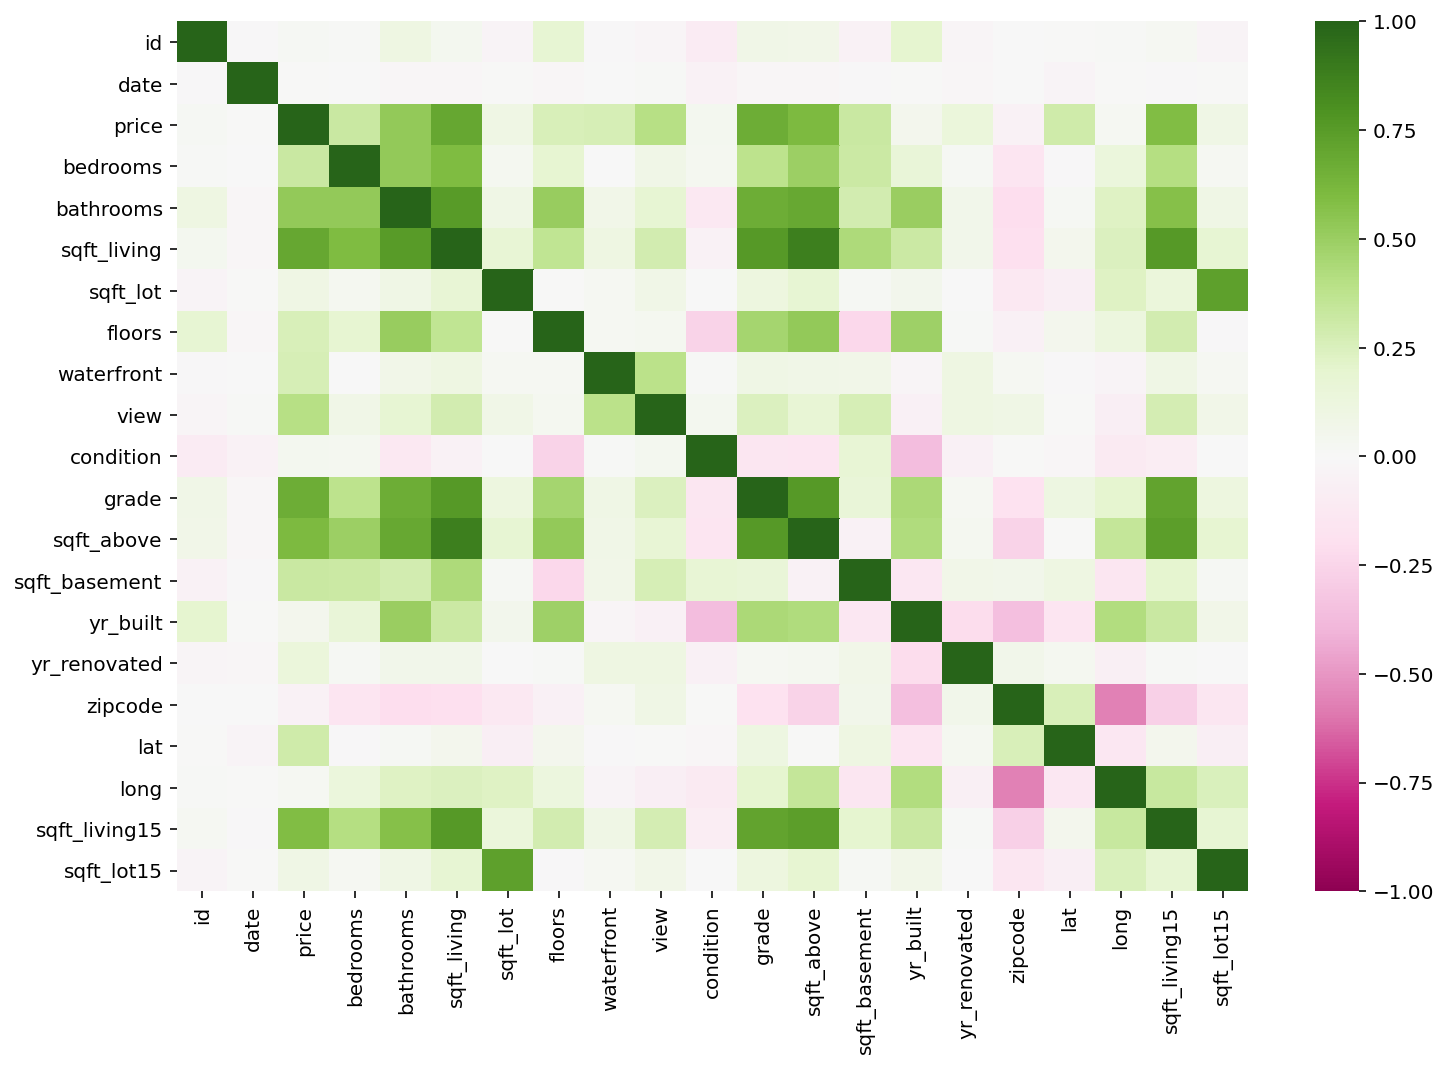

In [11]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)

df_heatmap = sns.heatmap(total_corr, vmin = -1, vmax = 1, cbar = True, fmt = '.2f', square = False, cmap = 'PiYG')


**상관 계수 0.1 이하인 것은 좀 더 파악하기**

(음수라서 첫번째로 나왔지만 상관 정도로 따지면 6위 정도) \\
우편번호 : 분명 중요할 것 같은데 상관계수가 낮게 나왔다. \\
값 자체가 중요한 게 아니라 범주형으로 파악해보기 위해서 다른 처리를 해보자 \\
우편번호가 같은 지역끼리 주거면적당 판매가 평균을 구해보자

거래 날짜 : 데이터가 1년치 데이터라 월별 차이 같은게 있지 않을까 했는데 상관도가 망해버림 \\
마찬가지로 범주형으로 파악하기 위해 주거면적당 판매가 평균을 내보자

id : 그냥 빼버리면 됨

long : lat과 다르게 long은 상관계수가 낮다 \\
위도에 따른 변화를 날씨로 설명하는 글도 있던데 \\
남북 끝의 위도 차이(47.1559 ~ 47.7776)를 따져보면 \\
경기도의 남북 위도 차이(36.87226 ~ 38.300603)보다 한참 작고 \\
서울의 남북 위도 차이(37.413294 ~ 37.715133)보다 조금 큰 정도인데 \\
이정도 차이로 집값에 영향을 줄 만큼 날씨가 급격히 바뀐다고 생각하기는 힘들다 \\
부유한 지역이 따로 있다고 보아야 할 듯 \\
위도 경도를 이용해서 도심과의 거리를 잡아볼까 생각도 하였으나 \\
도심이 어딘지 정확히 알 수가 없고 \\
서울의 강남처럼 거리보다는 방향이 중요할 수도 있어서 \\
가능하면 long은 삭제하고 lat만 활용해보기로 결정

condition : 도대체 알 수가 없는 데이터.. \\
집의 상태에 관한 데이터가 집 가격에 반영이 왜 안됐을까.. \\
우편번호나 날짜처럼 숫자 자체가 의미가 없는 데이터도 아닌데 .. \\
이유는 알 수 없지만 활용하기에도 찝찝 안하기도 찝찝

건축/재건축연도 : 건물의 연식보다 집의 상태가 더 중요한 것 같다. \\
주거면적당 판매가를 한번 확인해보자

부지면적 : 마찬가지로 주거면적의 크기가 중요하지 땅 크기가 중요하지는 않은 것 같다. \\








## 데이터 전처리

### 15 데이터 확인

재건축하지 않았는데도 값이 바뀌는 경우가 많다

재건축 여부 보다는 주변 건물들의 스펙으로 보는게 타당할 듯

(그렇다면 주변 평균과 완전히 일치하는 나머지 몇천개는 뭐지 아파트인가....)

원래는 재건축 된 경우라면 이전 데이터는 의미 없으므로 

renovated가 존재하면 15의 데이터를 덮어씌우려고 했는데

서로 다른 변수로 생각하고 진행해야겠다

In [12]:
# living과 living15가 다른 집의 재건축여부 확인
train_copy.loc[train_copy['sqft_living']!=train_copy['sqft_living15'],
               ['sqft_living', 'sqft_living15', 'yr_renovated']]

,sqft_living,sqft_living15,yr_renovated
0,1180,1340,0
1,770,2720,0
2,1680,1800,0
3,1715,2238,0
4,1060,1650,0
...,...,...,...
15026,3990,3370,0
15027,4470,2780,0
15028,1425,1285,0
15031,3510,2050,0


In [13]:
# lot과 lot15가 다른 집의 재건축여부 확인
train_copy.loc[train_copy['sqft_lot']!=train_copy['sqft_lot15'],
               ['sqft_lot', 'sqft_lot15', 'yr_renovated']]

,sqft_lot,sqft_lot15,yr_renovated
1,10000,8062,0
2,8080,7503,0
5,9796,8925,0
7,19901,12697,0
8,9680,10208,0
...,...,...,...
15029,5536,5731,0
15031,7200,6200,0
15032,1131,1509,0
15033,5813,7200,0


### 공간 갯수 컬럼 만들기

In [14]:
# 침실, 화장실 수를 합한 공간 컬럼 생성

train_copy['rooms'] = train_copy.apply(
        lambda d: (d['bedrooms'] + d['bathrooms']), axis=1)
train_copy

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,rooms
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,4.00
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,3.00
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,5.00
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,5.25
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,4.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,201410,610685.0,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023,6.50
15031,15031,201503,1007500.0,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200,7.50
15032,15032,201405,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,5.50
15033,15033,201502,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,6.50


### 방 갯수 비율 컬럼

In [15]:
train_copy['rooms_ratio'] = train_copy.apply(
        lambda d: (d['rooms']) / d['sqft_living'], axis=1)
train_copy

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,rooms,rooms_ratio
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,4.00,0.003390
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,3.00,0.003896
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,5.00,0.002976
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,5.25,0.003061
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,4.50,0.004245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,201410,610685.0,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023,6.50,0.002579
15031,15031,201503,1007500.0,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200,7.50,0.002137
15032,15032,201405,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,5.50,0.003595
15033,15033,201502,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,6.50,0.002814


In [16]:
# 쓸만한 상태가 되었는지 상관계수 확인 -> 써도 되겠다

total_corr = train_copy.corr()
total_corr['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.702899
grade            0.667211
sqft_above       0.608577
sqft_living15    0.586419
bathrooms        0.525479
rooms            0.475526
view             0.400806
bedrooms         0.323672
sqft_basement    0.322218
lat              0.301604
waterfront       0.265738
floors           0.262588
yr_renovated     0.140808
sqft_lot         0.096793
sqft_lot15       0.086384
yr_built         0.047290
condition        0.039740
long             0.023547
id               0.020899
date             0.007717
zipcode         -0.051498
rooms_ratio     -0.484260
Name: price, dtype: float64

### 변수 별 주거면적당 판매가 평균

In [17]:
# 주거면적당 판매가 구하는 함수 만들기
# 하나의 함수로 만들었었는데 
# 이후 price를 제거한 병합 데이터에 적용하려니 에러가 나서 기능을 두 개로 분리

def mean_price(data, col): # 데이터와 컬럼명을 인수로 받음
    sum_price = data.groupby([col])['price'].sum()
    sum_sqft = data.groupby([col])['sqft_living'].sum()
    price_per_sqft = (sum_price / sum_sqft).reset_index()
    price_per_sqft.rename(columns={0:col+'_pps'}, inplace = True)
    return price_per_sqft

# 구한 값을 새로운 컬럼에 적용하는 함수 만들기
def new_col(data, col, temp_col):
    data = pd.merge(data, temp_col, how = 'left', on = [col])
    return data

#### zipcode

In [18]:
# 우편번호 별 평균가 컬럼 생성

zip_pps = mean_price(train_copy, 'zipcode')
train_copy = new_col(train_copy, 'zipcode', zip_pps)
train_copy

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,rooms,rooms_ratio,zipcode_pps
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,4.00,0.003390,179.194408
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,3.00,0.003896,215.945386
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,5.00,0.002976,262.166148
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,5.25,0.003061,153.896452
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,4.50,0.004245,172.927067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,201410,610685.0,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023,6.50,0.002579,210.285953
15031,15031,201503,1007500.0,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200,7.50,0.002137,320.586077
15032,15032,201405,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,5.50,0.003595,356.918605
15033,15033,201502,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,6.50,0.002814,219.373147


In [19]:
# 쓸만한 상태가 되었는지 상관계수 확인 -> 써도 되겠다

total_corr = train_copy.corr()
total_corr['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.702899
grade            0.667211
sqft_above       0.608577
sqft_living15    0.586419
zipcode_pps      0.545218
bathrooms        0.525479
rooms            0.475526
view             0.400806
bedrooms         0.323672
sqft_basement    0.322218
lat              0.301604
waterfront       0.265738
floors           0.262588
yr_renovated     0.140808
sqft_lot         0.096793
sqft_lot15       0.086384
yr_built         0.047290
condition        0.039740
long             0.023547
id               0.020899
date             0.007717
zipcode         -0.051498
rooms_ratio     -0.484260
Name: price, dtype: float64

#### date

In [20]:
# 월별 평균가 컬럼 생성

mon_pps = mean_price(train_copy, 'date')
train_copy = new_col(train_copy, 'date', mon_pps)
train_copy

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,rooms,rooms_ratio,zipcode_pps,date_pps
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,4.00,0.003390,179.194408,258.681447
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,3.00,0.003896,215.945386,254.074437
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,5.00,0.002976,262.166148,254.074437
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,5.25,0.003061,153.896452,260.409158
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,4.50,0.004245,172.927067,250.370140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,201410,610685.0,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023,6.50,0.002579,210.285953,258.681447
15031,15031,201503,1007500.0,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200,7.50,0.002137,320.586077,266.993679
15032,15032,201405,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,5.50,0.003595,356.918605,259.721167
15033,15033,201502,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,6.50,0.002814,219.373147,254.074437


In [21]:
# 쓸만한 상태가 되었는지 상관계수 확인 -> 별 소용 없는 것 같다

total_corr = train_copy.corr()
total_corr['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.702899
grade            0.667211
sqft_above       0.608577
sqft_living15    0.586419
zipcode_pps      0.545218
bathrooms        0.525479
rooms            0.475526
view             0.400806
bedrooms         0.323672
sqft_basement    0.322218
lat              0.301604
waterfront       0.265738
floors           0.262588
yr_renovated     0.140808
sqft_lot         0.096793
sqft_lot15       0.086384
yr_built         0.047290
condition        0.039740
date_pps         0.031438
long             0.023547
id               0.020899
date             0.007717
zipcode         -0.051498
rooms_ratio     -0.484260
Name: price, dtype: float64

#### yr_built, yr_renovated

In [22]:
# yr_renovated의 값이 존재하는 경우 yr_renovated를 yr_built로 대체

train_copy['yr_since'] = train_copy['yr_built'] # 새로운 컬럼 생성해서 built 값으로 채움
train_copy.loc[train_copy['yr_renovated'] != 0, 'yr_since'] = train_copy['yr_renovated']
# renovated 값이 존재하는 경우 대체
train_copy

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,rooms,rooms_ratio,zipcode_pps,date_pps,yr_since
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,4.00,0.003390,179.194408,258.681447,1955
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,3.00,0.003896,215.945386,254.074437,1933
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,5.00,0.002976,262.166148,254.074437,1987
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,5.25,0.003061,153.896452,260.409158,1995
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,4.50,0.004245,172.927067,250.370140,1963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,201410,610685.0,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023,6.50,0.002579,210.285953,258.681447,2014
15031,15031,201503,1007500.0,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200,7.50,0.002137,320.586077,266.993679,2009
15032,15032,201405,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,5.50,0.003595,356.918605,259.721167,2009
15033,15033,201502,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,6.50,0.002814,219.373147,254.074437,2014


In [23]:
# 연도별 평균가 컬럼 생성

yr_pps = mean_price(train_copy, 'yr_since')
train_copy = new_col(train_copy, 'yr_since', yr_pps)
train_copy

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,rooms,rooms_ratio,zipcode_pps,date_pps,yr_since,yr_since_pps
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,4.00,0.003390,179.194408,258.681447,1955,253.857070
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,3.00,0.003896,215.945386,254.074437,1933,338.456571
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,5.00,0.002976,262.166148,254.074437,1987,252.799245
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,5.25,0.003061,153.896452,260.409158,1995,254.497761
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,4.50,0.004245,172.927067,250.370140,1963,241.474524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,201410,610685.0,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023,6.50,0.002579,210.285953,258.681447,2014,269.355211
15031,15031,201503,1007500.0,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200,7.50,0.002137,320.586077,266.993679,2009,267.016623
15032,15032,201405,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,5.50,0.003595,356.918605,259.721167,2009,267.016623
15033,15033,201502,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,6.50,0.002814,219.373147,254.074437,2014,269.355211


In [24]:
# 쓸만한 상태가 되었는지 상관계수 확인 -> 별 소용 없는 것 같다

total_corr = train_copy.corr()
total_corr['price'].sort_values(ascending=False)

price            1.000000
sqft_living      0.702899
grade            0.667211
sqft_above       0.608577
sqft_living15    0.586419
zipcode_pps      0.545218
bathrooms        0.525479
rooms            0.475526
view             0.400806
bedrooms         0.323672
sqft_basement    0.322218
lat              0.301604
waterfront       0.265738
floors           0.262588
yr_renovated     0.140808
yr_since         0.102547
sqft_lot         0.096793
sqft_lot15       0.086384
yr_since_pps     0.068791
yr_built         0.047290
condition        0.039740
date_pps         0.031438
long             0.023547
id               0.020899
date             0.007717
zipcode         -0.051498
rooms_ratio     -0.484260
Name: price, dtype: float64

### 주거면적당 판매가 컬럼 생성

In [25]:
train_copy['price_per_area'] = train_copy.apply(
        lambda d: (d['price'] / d['sqft_living']), axis=1)
train_copy

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,rooms,rooms_ratio,zipcode_pps,date_pps,yr_since,yr_since_pps,price_per_area
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,4.00,0.003390,179.194408,258.681447,1955,253.857070,188.050847
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,3.00,0.003896,215.945386,254.074437,1933,338.456571,233.766234
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,5.00,0.002976,262.166148,254.074437,1987,252.799245,303.571429
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,5.25,0.003061,153.896452,260.409158,1995,254.497761,150.145773
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,4.50,0.004245,172.927067,250.370140,1963,241.474524,275.330189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15030,15030,201410,610685.0,4,2.50,2520,6023,2.0,0,0,3,9,2520,0,2014,0,98056,47.5137,-122.167,2520,6023,6.50,0.002579,210.285953,258.681447,2014,269.355211,242.335317
15031,15031,201503,1007500.0,4,3.50,3510,7200,2.0,0,0,3,9,2600,910,2009,0,98136,47.5537,-122.398,2050,6200,7.50,0.002137,320.586077,266.993679,2009,267.016623,287.037037
15032,15032,201405,360000.0,3,2.50,1530,1131,3.0,0,0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,5.50,0.003595,356.918605,259.721167,2009,267.016623,235.294118
15033,15033,201502,400000.0,4,2.50,2310,5813,2.0,0,0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,6.50,0.002814,219.373147,254.074437,2014,269.355211,173.160173


### 위도, 경도 확인

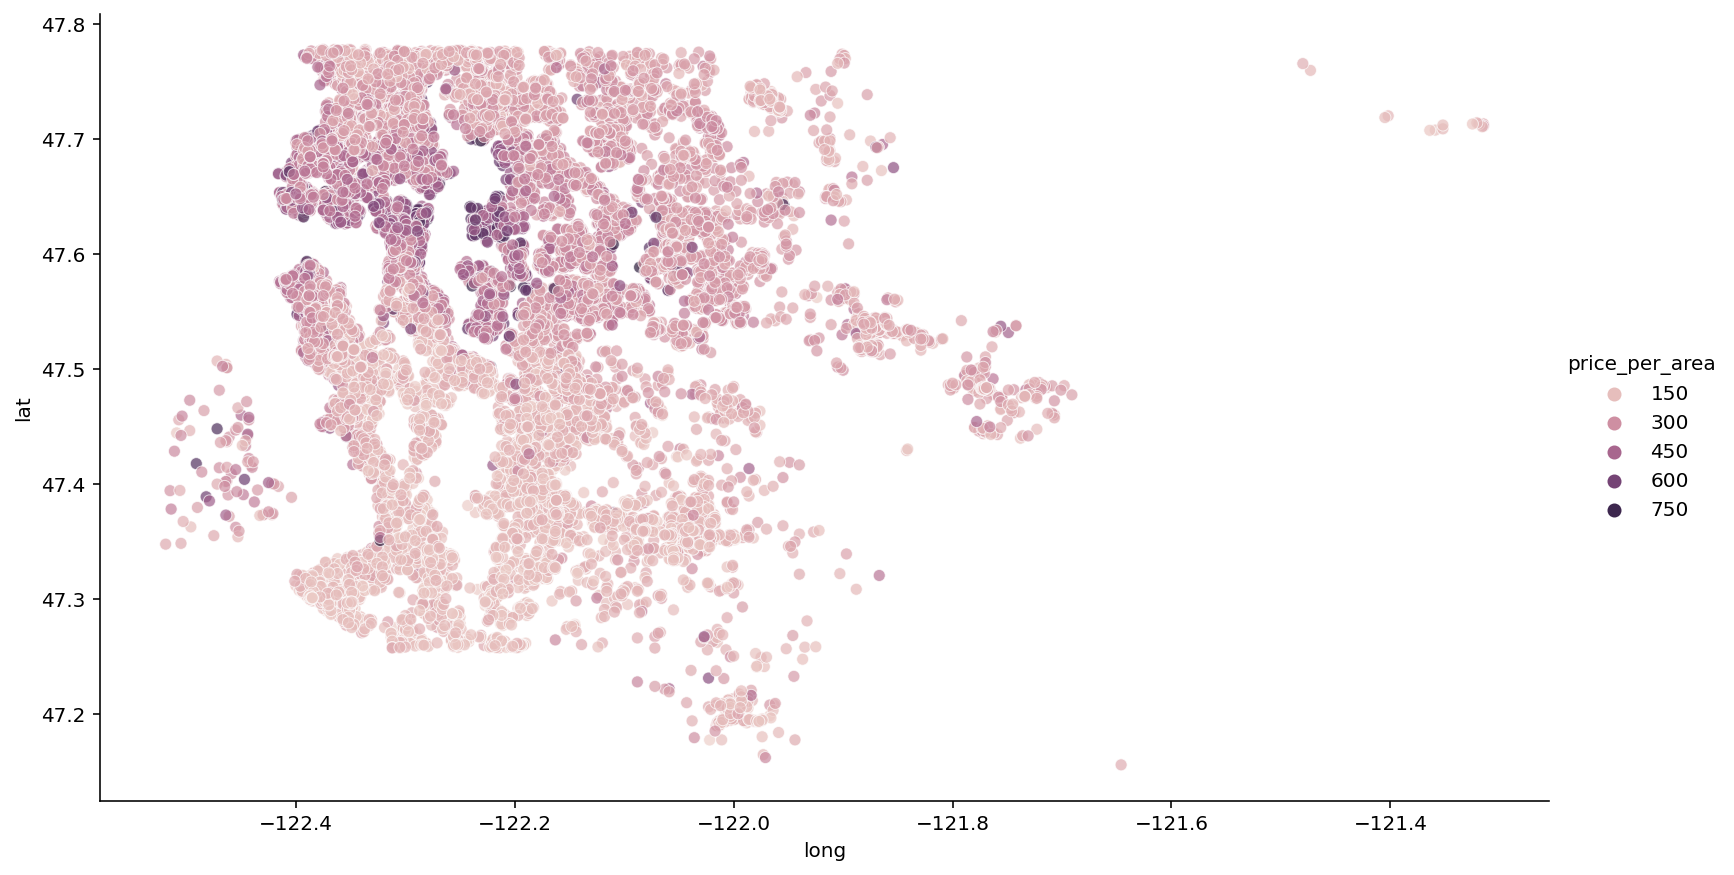

In [26]:
sns.relplot(x = 'long', y = 'lat', hue = 'price_per_area', alpha = 0.7, height = 6, aspect = 1.8, data = train_copy)

# 지역에 따라 집값에 유의미한 차이가 있기는 한 것 같은데 
# 위경도의 특징을 한번에 나타내는 피처를 어떻게 뽑아내야 할지 모르겠다

### 데이터 셋을 합친 후 컬럼 정리

In [27]:
# test의 id 컬럼은 따로 저장해두기
# train에만 있는 타겟인 price 컬럼은 따로 저장 후 삭제

sub_id = test['id']

y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [28]:
# 트레인 데이터 개수 확인 후 데이터 병합

#train_len = len(train_copy)
#union = pd.concat((train_copy, test), axis=0)

train_len = len(train)
union = pd.concat((train, test), axis=0)

print(len(train))
print(len(union))

union

15035
21503


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6463,21498,201406,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
6464,21499,201501,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
6465,21500,201502,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265
6466,21501,201406,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007


In [29]:
# id를 index로 설정

union.set_index('id', inplace = True)
print(union.columns)
union

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,,,,,,,,,,,,,,,,,,,
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,201406,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303
21499,201501,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230
21500,201502,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265


In [30]:
# 앞에서 train 데이터로 얻은  정보를 union에 적용

union = new_col(union, 'zipcode', zip_pps)
union = new_col(union, 'date', mon_pps)

union['yr_since'] = union['yr_built'] # 새로운 컬럼 생성해서 built 값으로 채움
union.loc[union['yr_renovated'] != 0, 'yr_since'] = union['yr_renovated'] # renovated 값이 존재하는 경우 대체
union = new_col(union, 'yr_since', yr_pps)

union['rooms'] = union.apply(
        lambda d: (d['bedrooms'] + d['bathrooms']), axis=1)
union['rooms_ratio'] = union.apply(
        lambda d: (d['rooms']) / d['sqft_living'], axis=1)

union

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,zipcode_pps,date_pps,yr_since,yr_since_pps,rooms,rooms_ratio
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,179.194408,258.681447,1955,253.857070,4.00,0.003390
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,215.945386,254.074437,1933,338.456571,3.00,0.003896
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,262.166148,254.074437,1987,252.799245,5.00,0.002976
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,153.896452,260.409158,1995,254.497761,5.25,0.003061
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,172.927067,250.370140,1963,241.474524,4.50,0.004245
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,201406,3,1.75,1500,11968,1.0,0,0,3,6,1500,0,2014,0,98010,47.3095,-122.002,1320,11303,196.377117,260.409158,2014,269.355211,4.75,0.003167
21499,201501,3,2.00,1490,1126,3.0,0,0,3,8,1490,0,2014,0,98144,47.5699,-122.288,1400,1230,319.051158,250.370140,2014,269.355211,5.00,0.003356
21500,201502,3,2.50,1310,1294,2.0,0,0,3,8,1180,130,2008,0,98116,47.5773,-122.409,1330,1265,336.468096,254.074437,2008,283.499054,5.50,0.004198
21501,201406,2,0.75,1020,1350,2.0,0,0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,319.051158,260.409158,2009,267.016623,2.75,0.002696


In [31]:
# 결측치 확인 -> 없으니 그대로 진행

for c in union.columns:
    print('{:>14} : {}'.format(c, len(union.loc[pd.isnull(union[c]), c].values)))

          date : 0
      bedrooms : 0
     bathrooms : 0
   sqft_living : 0
      sqft_lot : 0
        floors : 0
    waterfront : 0
          view : 0
     condition : 0
         grade : 0
    sqft_above : 0
 sqft_basement : 0
      yr_built : 0
  yr_renovated : 0
       zipcode : 0
           lat : 0
          long : 0
 sqft_living15 : 0
    sqft_lot15 : 0
   zipcode_pps : 0
      date_pps : 0
      yr_since : 0
  yr_since_pps : 0
         rooms : 0
   rooms_ratio : 0


하이퍼 파라미터를 고정해두고 컬럼들을 바꿔가며 스코어를 계산해 본 결과.

열심히 컬럼들을 만들어봤지만 별 도움은 되지 않았고,

모든 케이스를 다 실험해보지는 못했지만 생각나는대로 RSMSE 값을 체크해보았는데

가장 괜찮은 케이스는 우편번호별 평당가격을 이용하고, 지하실 면적 정보는 제외한 것이었음.
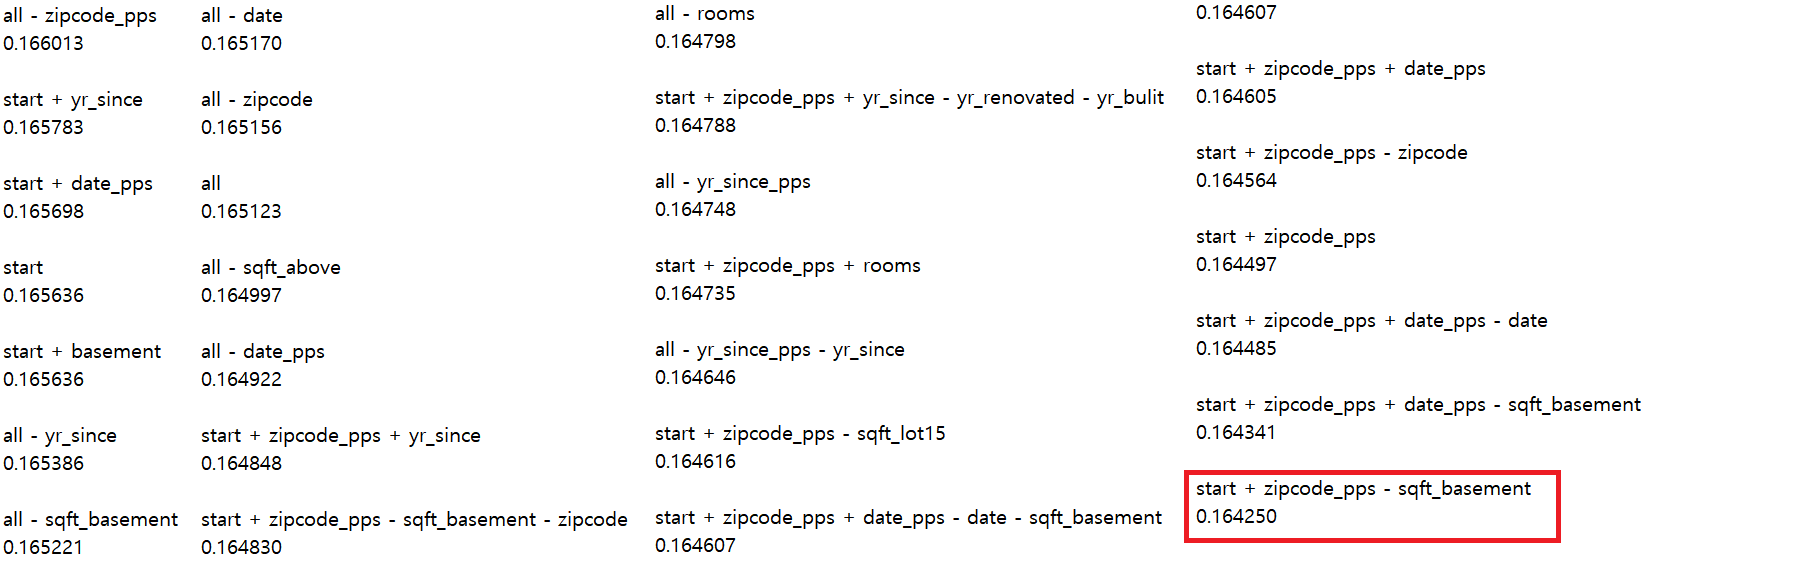

In [32]:
# 쓰지 않을 컬럼들 삭제 
# 'condition', 'waterfront', 'sqft_lot', 'sqft_lot15', 'lat', 'long'
# 'zipcode',  'date', 'yr_renovated', 'yr_built'
# 'bedrooms', 'bathrooms', , 'sqft_above' , 

# , 'zipcode_pps'

drop_col = ['date_pps', 'yr_since', 'rooms', 'yr_since_pps', 'rooms_ratio',
            'sqft_basement']
union = union.drop(drop_col, axis = 1)
union

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,zipcode_pps
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,1955,0,98178,47.5112,-122.257,1340,5650,179.194408
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,1933,0,98028,47.7379,-122.233,2720,8062,215.945386
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,1987,0,98074,47.6168,-122.045,1800,7503,262.166148
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,1995,0,98003,47.3097,-122.327,2238,6819,153.896452
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,1963,0,98198,47.4095,-122.315,1650,9711,172.927067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21498,201406,3,1.75,1500,11968,1.0,0,0,3,6,1500,2014,0,98010,47.3095,-122.002,1320,11303,196.377117
21499,201501,3,2.00,1490,1126,3.0,0,0,3,8,1490,2014,0,98144,47.5699,-122.288,1400,1230,319.051158
21500,201502,3,2.50,1310,1294,2.0,0,0,3,8,1180,2008,0,98116,47.5773,-122.409,1330,1265,336.468096
21501,201406,2,0.75,1020,1350,2.0,0,0,3,7,1020,2009,0,98144,47.5944,-122.299,1020,2007,319.051158


In [33]:
# function to calculate VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# calculating VIF
X = train_copy.drop(drop_col+['id'], axis = 1)

VIF = pd.DataFrame()
VIF["features"] = X.columns
VIF["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
VIF.sort_values(ascending=False,inplace=True,by='VIF')
VIF.round(1)


,features,VIF
14,zipcode,5045328.8
0,date,3825182.3
16,long,1408041.7
15,lat,211127.3
12,yr_built,12108.8
10,grade,162.7
4,sqft_living,86.8
19,zipcode_pps,42.9
20,price_per_area,42.4
11,sqft_above,42.2


아무래도 원래 있던 변수들을 엮어서 새로운 변수를 만들기도 했고,

기존에 존재하는 변수들 끼리도 상관관계가 높은 것들이 있어서 다중공선성을 확인해보고 싶었다

역시나 몇면 변수에서 값이 폭팔하고, 새로운 변수를 추가한 경우 inf 값도 뜨는 등 난리도 아니었다

시간 부족으로 확인 한 케이스들을 다 이미지화는 못했는데 ㅠㅠ

vif를 낮춰야 학습 결과가 좋아진다고 했는데 나는 왜 vif를 낮추려면 결과가 더 나빠질까..

현재 VIF가 가장 높고 대체할 zipcode_pps 컬럼이 있는 zipcode 컬럼을 삭제한 경우

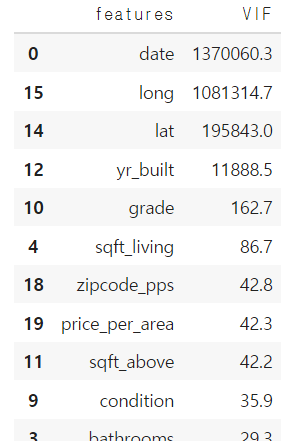

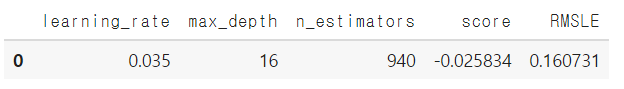


### 각 변수들의 분포 확인

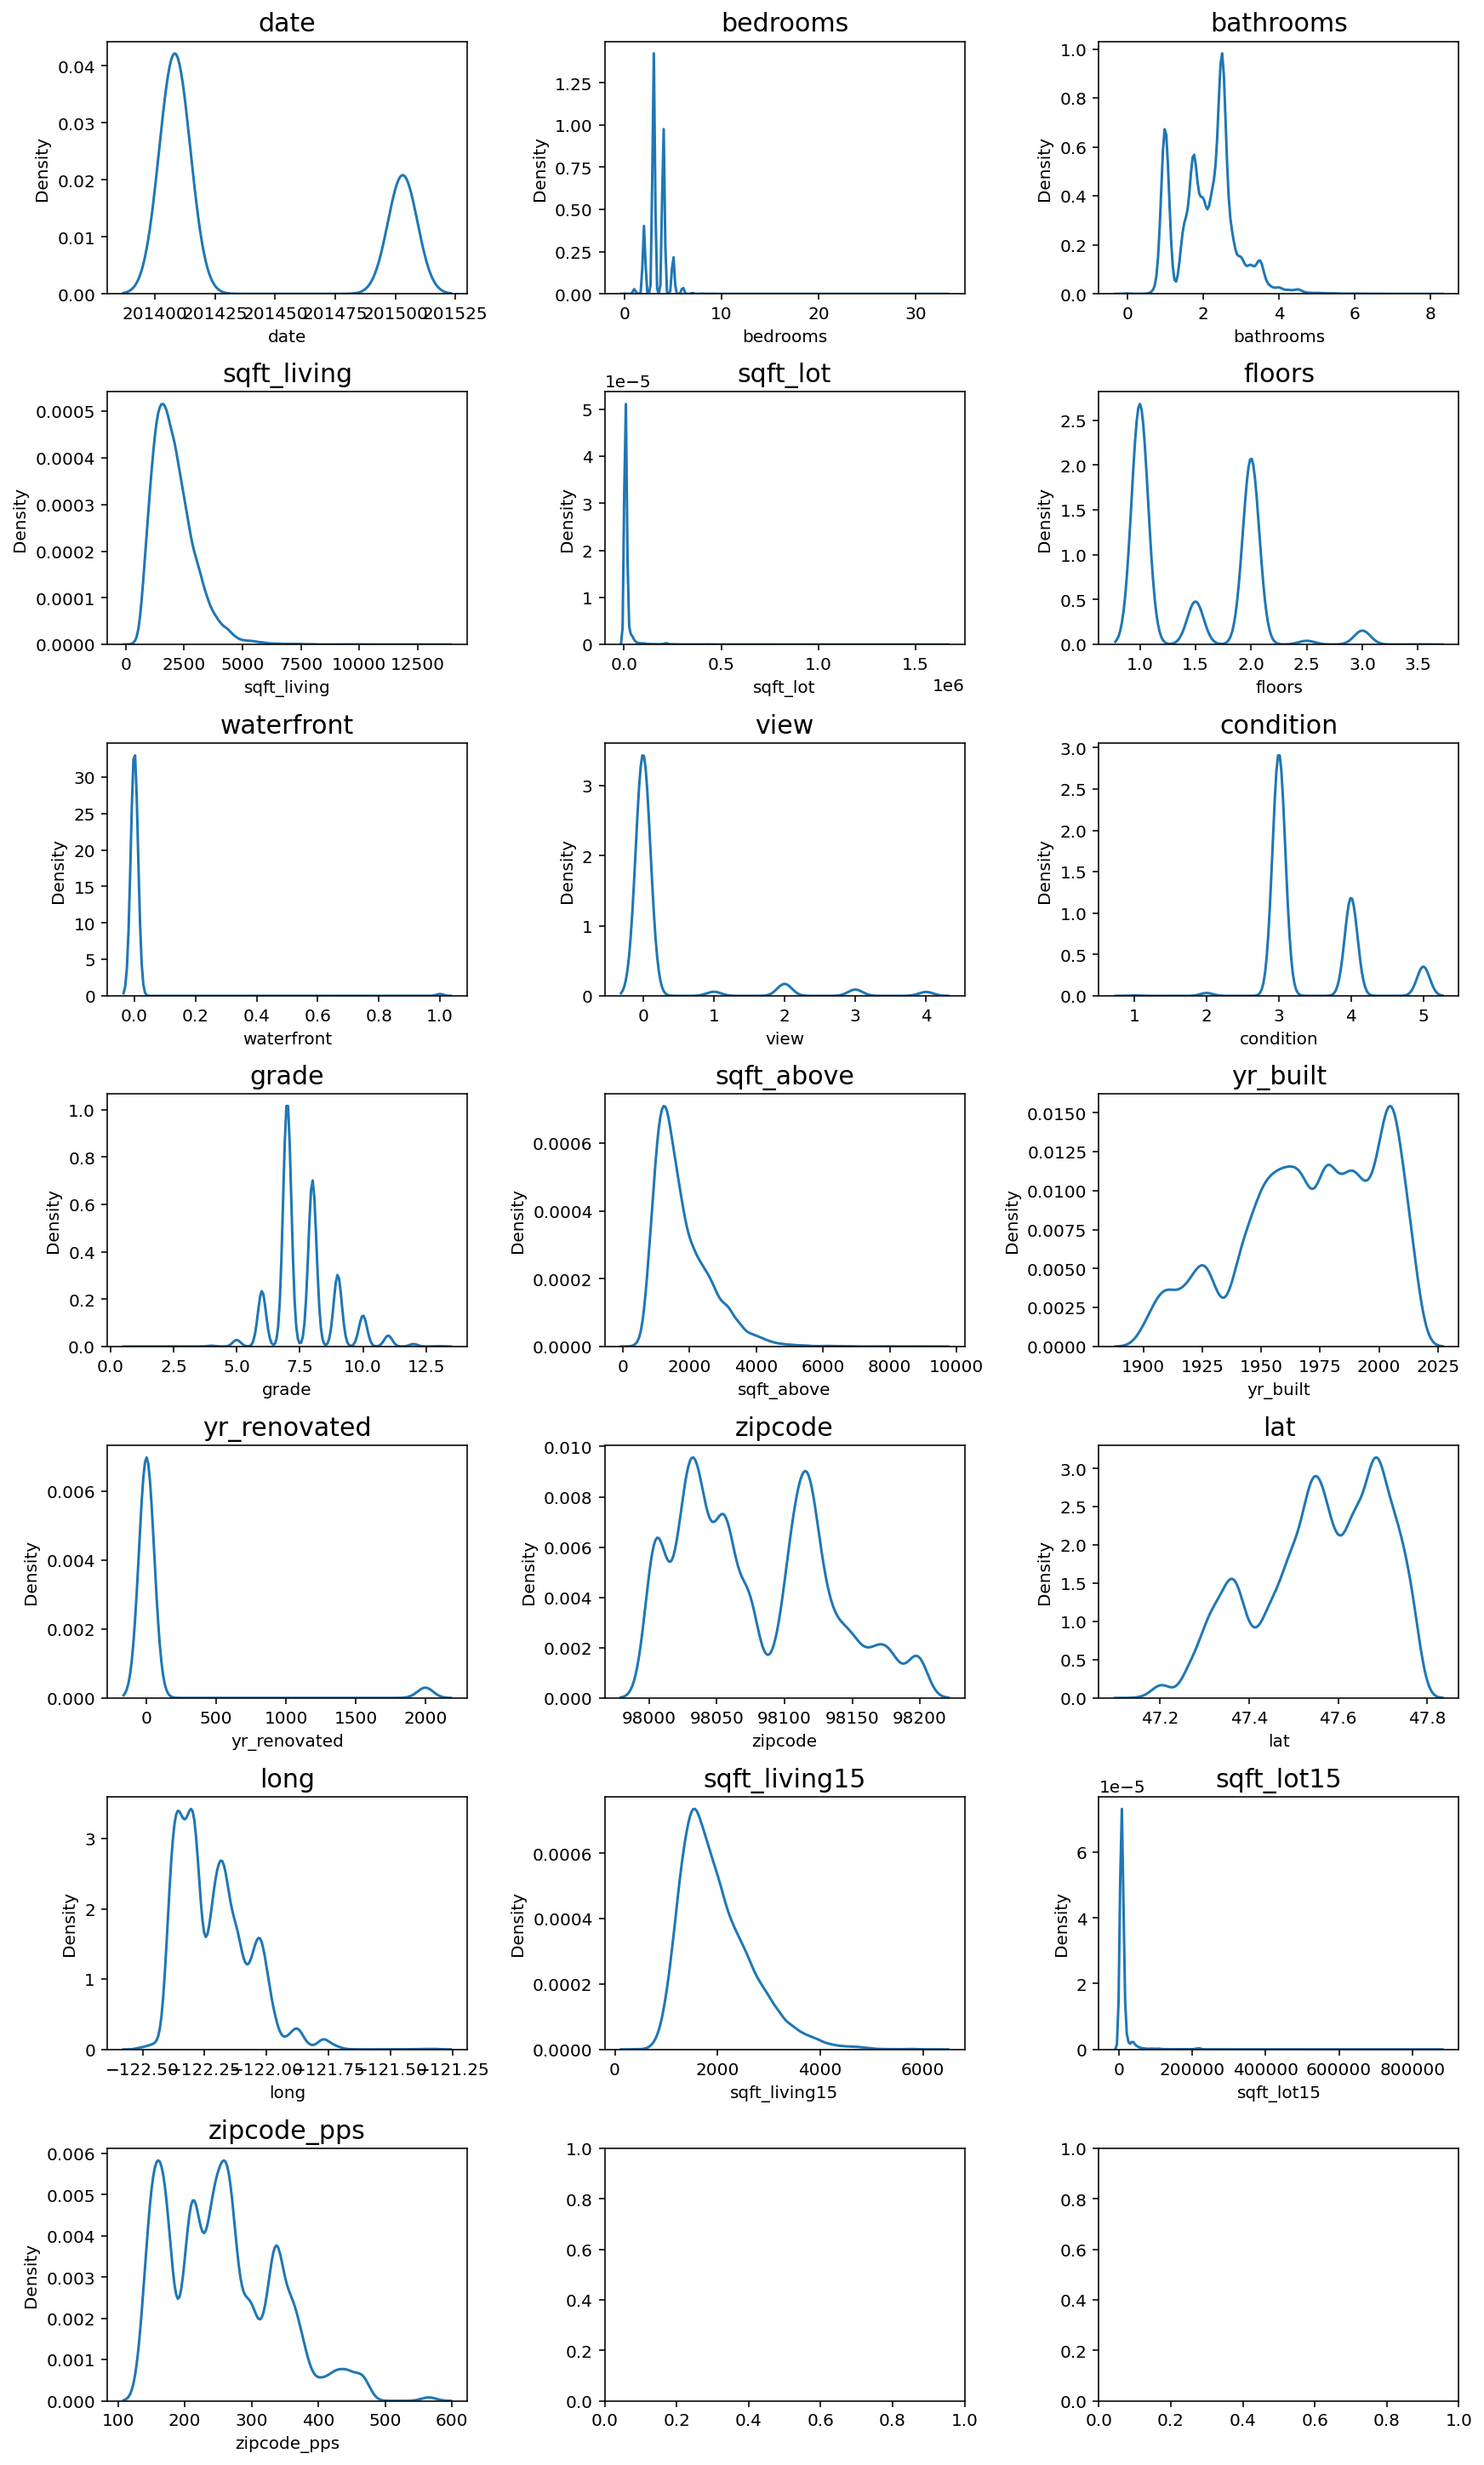

In [34]:
fig, ax = plt.subplots(7, 3, figsize=(12, 20), constrained_layout=True) 

count = 0
columns = union.columns
for row in range(7):
    for col in range(3):
        sns.kdeplot(union[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == len(union.columns) :
            break

In [633]:
for col in union.columns:
    if union[col].skew() > 2:
        print('{:15}'.format(col), 'Skewness: {:05.2f}'.format(union[col].skew()))

# waterfront와 yr_renovated는 0이 많은 데이터이므로 로그변환x
# veiw도 범주형 데이터이므로 로그변환 x
# 그림으로는 sqft 가 모두 치우쳐보이는데 실제로 왜도가 크지는 않다

sqft_lot        Skewness: 13.06
waterfront      Skewness: 11.36
view            Skewness: 03.39
yr_renovated    Skewness: 04.54
sqft_lot15      Skewness: 09.51


#### 분포가 한쪽으로 치우친 변수 보정

In [634]:
# 치우친 컬럼들을 skew_columns 리스트 안에 담고
# np.log1p()를 활용해서 로그 변환
# numpy.log1p() 함수는 각 요소에 대해 자연로그 log(1 + x)을 반환해 주는 함수

skew_columns = ['sqft_lot', 'sqft_lot15']

for c in skew_columns:
    union[c] = np.log1p(union[c].values)

print('done')

done


(<matplotlib.axes._subplots.AxesSubplot at 0x7f967f322390>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f967f322390>)

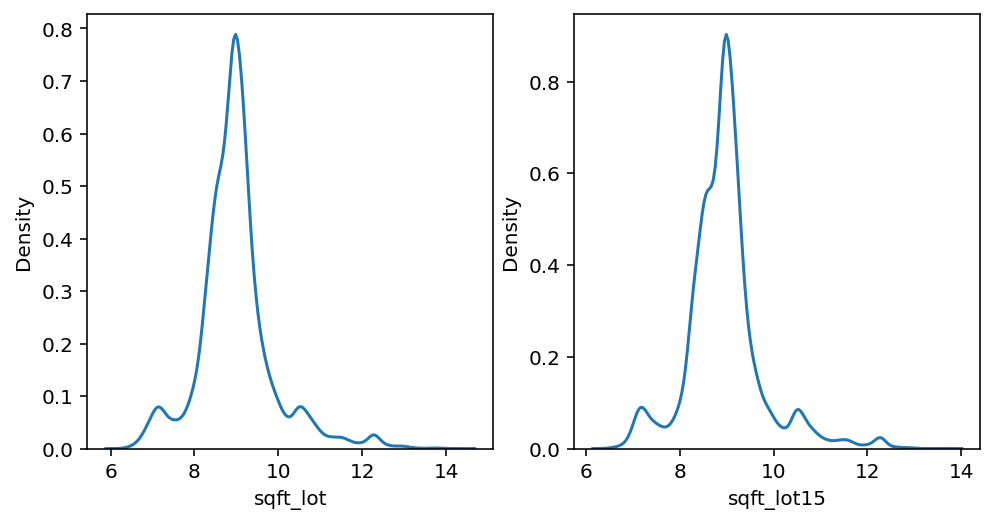

In [635]:
plt.figure(figsize=(8, 4))
plt.subplot(121),sns.kdeplot(union['sqft_lot'])
plt.subplot(122),sns.kdeplot(union['sqft_lot15'])

### bedrooms 이상치 확인

In [636]:
# 침실이 30개 초과인 집 확인

union.loc[union['bedrooms'] > 30, ['bedrooms']]

,bedrooms
19745,33


(<matplotlib.axes._subplots.AxesSubplot at 0x7f967fd36390>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f967fd36390>)

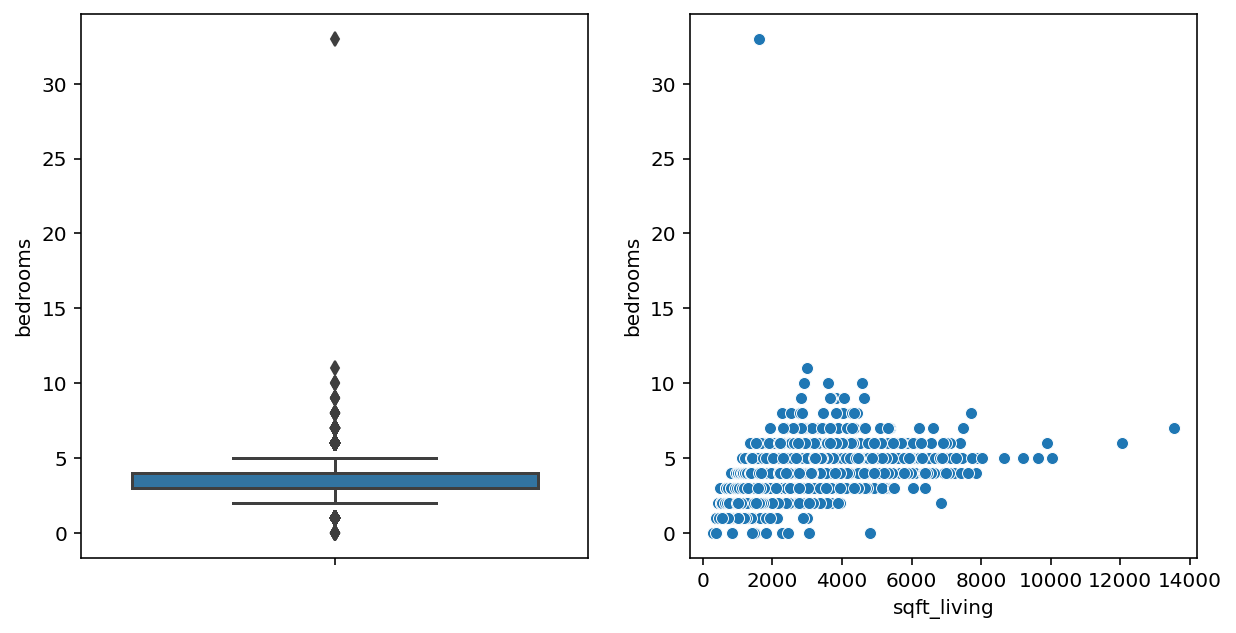

In [637]:
# bedrooms의 사분위수와, 주거면적당 침실의 개수 산점도 확인

plt.figure(figsize=(10, 5))
plt.subplot(121),sns.boxplot(y='bedrooms', data=union)
plt.subplot(122),sns.scatterplot(x = 'sqft_living', y = 'bedrooms', data=union)

,bedrooms
19745,3


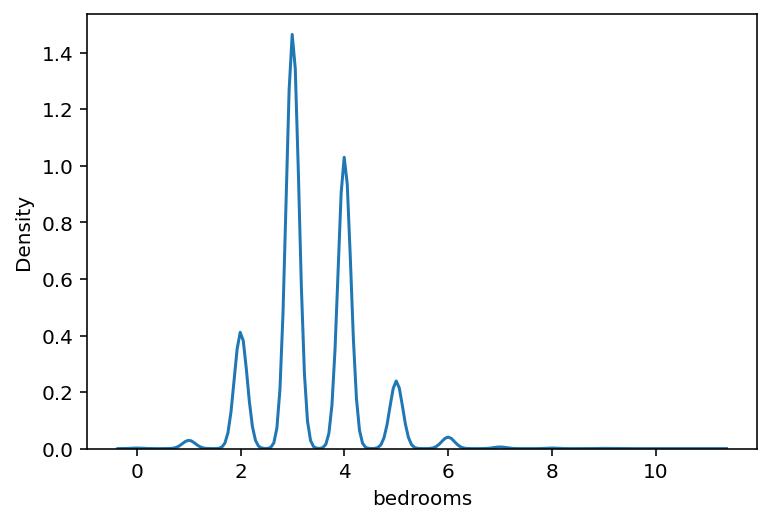

In [638]:
# 아무리 봐도 침실 3개가 오타난 것 같아서 임의로 대체해줌

union.loc[19745,'bedrooms'] = 3
sns.kdeplot(union['bedrooms'])
union.loc[[19745],['bedrooms']]

In [639]:
# 전체 데이터 다시 분할

sub = union.iloc[train_len:, :] # 트레인 데이터 개수 이후부터는 타겟
x = union.iloc[:train_len, :] # 트레인 데이터 이전은 학습용

print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


### 타겟 데이터 확인

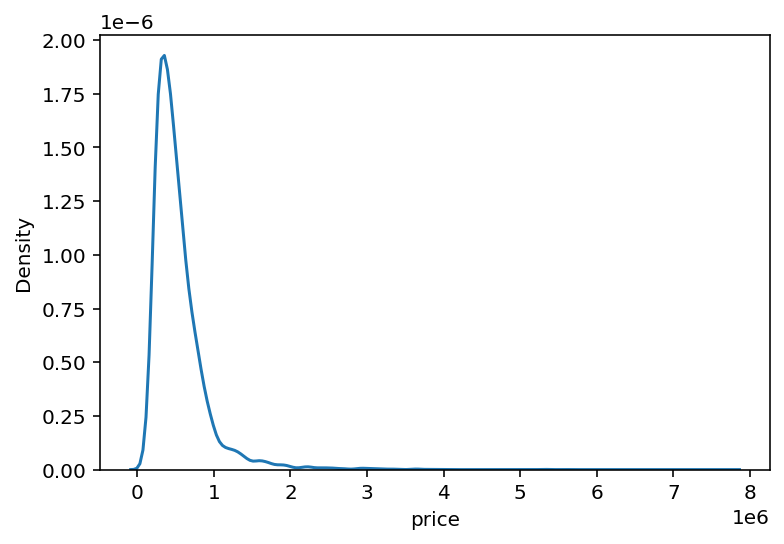

In [640]:
# y의 분포 확인

sns.kdeplot(y)
plt.show()

In [641]:
print('price Skewness: {:05.2f}'.format(y.skew()))

price Skewness: 04.29


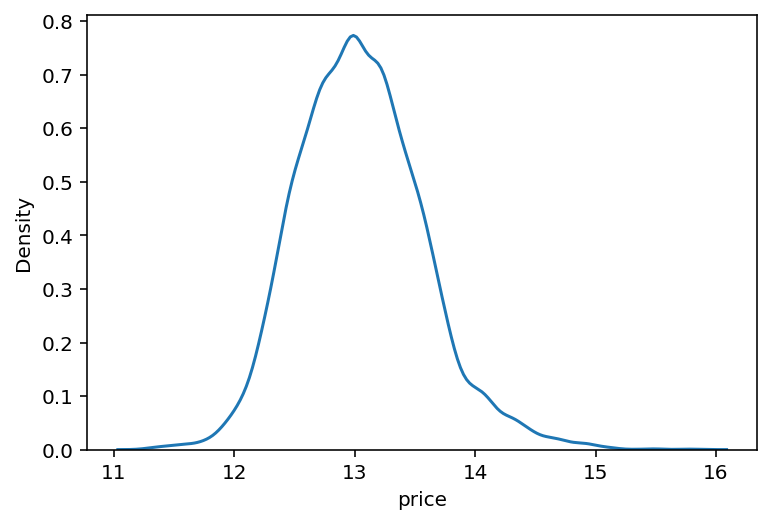

In [642]:
# 로그 변환을 해주고 나중에 되돌리자
# np.log1p() 와 np.exp1m() 을 이용

y = np.log1p(y)

sns.kdeplot(y)
plt.show()

In [643]:
print('price Skewness: {:05.2f}'.format(y.skew()))
y

price Skewness: 00.43


0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

## 모델 만들기

In [644]:
# 데이터셋 분할과 RMSE 점수를 계산하기 위한 모듈을 임포트

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

print('done')

done


In [645]:
# RMSE 계산을 위한 함수 작성
# y_test나 y_pred는 로그변환된 값이므로 환산해줘야함

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

print('done')

done


In [646]:
# 네가지 모델을 가져오기

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

print('done')

done


In [647]:
# 모델 인스턴스를 생성한 후 리스트에 넣어주기

# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
random_state=2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

print('done')

done


In [648]:
# 해당 작업을 함수로 만들기

def get_scores(models, x, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
        
        X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE')
            
    return score_df

get_scores(models, x, y)

,RMSE
LGBMRegressor,107346.089910
XGBRegressor,110003.259741
GradientBoostingRegressor,116087.226759
RandomForestRegressor,120392.475414


In [649]:
# GridSearchCV 임포트

from sklearn.model_selection import GridSearchCV

print('done')

done


In [650]:
"""
다음과 같은 과정을 진행할 수 있는 `my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)` 함수를 구현해 보세요.

1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다. 
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""

def my_GridSearch(model, x, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델 fitting
    grid_model.fit(x, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results

print('done')

done


In [651]:
# 생성한 함수로 그리드 탐색

param_grid = {
    'learning_rate' : [0.034, 0.035, 0.036],
    'n_estimators': [930, 940, 950],
    'max_depth': [15, 16,17],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, x, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


,learning_rate,max_depth,n_estimators,score,RMSLE
13,0.035,16,940,-0.025534,0.159795
14,0.035,16,950,-0.025535,0.159796
12,0.035,16,930,-0.025543,0.159821
19,0.036,15,940,-0.025585,0.159952
18,0.036,15,930,-0.025592,0.159976
20,0.036,15,950,-0.025595,0.159984
24,0.036,17,930,-0.025600,0.159999
11,0.035,15,950,-0.025602,0.160006
26,0.036,17,950,-0.025603,0.160008
25,0.036,17,940,-0.025603,0.160011


In [ ]:
"""
아래의 과정을 수행하는 `save_submission(model, x, y, test, model_name, rmsle)` 함수를 구현해 주세요.
1. 모델을 `x`, `y`로 학습시킵니다.
2. `test`에 대해 예측합니다.
3. 예측값을 `np.expm1`으로 변환하고, `submission_model_name_RMSLE_100000.csv` 형태의 `csv` 파일을 저장합니다.
"""

def save_submission(model, x, y, test, model_name, rmsle=None):
    model.fit(x, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = '/content/drive/MyDrive/Colab/kakr/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

print('done')

In [ ]:
model = LGBMRegressor(learning_rate = 0.035, max_depth=16, n_estimators=940, random_state=random_state)
save_submission(model, train, y, test, 'lgbm', rmsle='0.159795')

## 캐글 제출 결과

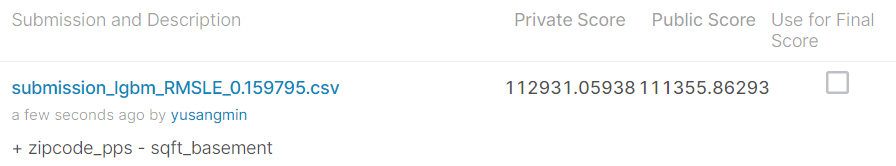


# 회고

#### 첫번째시도

가장 먼저 생각 한 건

15 변수가 정말로 재건축 데이터라면 건물이 새로 지어졌으므로

기존의 데이터는 의미가 없는 것이 아닌가 하는 의심이었다.

그래서 건축 연도와 면적 정보를 대체하려고 생각 했으나, 그렇다면 다른 건물 정보가 다 Nan이 될 것 같아서 고민 하던 중에

재건축 데이터가 아니라는 글을 보고 확인 한 결과 주위 집들의 스펙이라는 결론을 내림

#### 두번째시도

상관계수를 이용해서, price와 상관관계가 적은 변수는 아예 제거하려고 시도해보았는데

점수가 개선되기는 커녕 점점 더 나빠져갔다.

상관이 없는 데이터가 섞여있으면 학습에 방해될 것 같은데

알 수 없는 블랙박스...

#### 세번째시도

zipcode나 date 같은 정보는 숫자로 나타나있기는 하지만,\
실질적으로 숫자의 의미는 없고 카테고리의 역할 정도만 하고 있다.
(시계열 해석은 포기했으므로..)

따라서 좀 더 제대로 학습시키기 위해 다시 라벨링을 시도했다.

각각의 변수 별로 평당 가격을 구해서 의미가 있는 숫자로 레이블 인코딩을 시도했는데\
실질적으로 zippcode만 제대로 적용 되었고, 날짜나 연도 관련해서는 별 의미가 없는 작업이었다

#### 네번째시도

세번째 시도에서 이상한 현상이 포착되었는데 \
레이블 인코딩 하느라 변수 개수가 늘어날수록 학습성능이 좋아지는 것이다

원래 예상은 특징을 뽑아낸 새로운 피처를 만들면 기존의 피처는 지우려고 했는데\
기존 정보를 지우면 성능이 떨어져버림...

그래서 새로운 컬럼을 마구 만들어보자 라는 결론에 도달했고\
방에 관련된 변수나, 안쓰고 버리려던 위경도 데이터로도 새로운 컬럼을 만들어보려고 시도

#### 다섯번째시도

한창 새로운 컬럼만들기 놀이를 할때쯤 해커톤을 진행하며 다중공선성이라는 개념을 배웠다.

변수들간의 상관관계가 높으면 제대로 학습이 되지 않을 가능성이 있다고 해서 급하게 확인해보니\
vif가 5나 10 정도를 기준으로 한다는데....

값들이 미쳐날뛰고 있습니다....

변수를 이것저것 삭제하면서 vif를 관리 해보았으나

vif가 줄어들면 학습 성능이 떨어진다!

집 값이라는게, 애초에 변수들 간 상관관계가 높을 수 밖에 없는 데이터라서 그럴까..

이유를 알 수는 없지만 vif는 확인해봤다는데 의의를 두고 폐기

#### 여섯번째시도

결국 어떤 피처를 사용할 지는 RMSLE 값을 직접 확인해가면서 뽑아내는 수 밖에 없었다.

모든 케이스를 확인하지는 못했지만 zipcode_pps 컬럼을 추가한 경우 값이 큰 폭으로 떨어졌다.

연관이 있을 것 같은 조합들을 많이 시도해보았는데 다 실패했고\
그나마 지하실 면적이 living에도 영향을 주면서 집 값 자체에는 크게 영향을 안 줘서 그런지\
빼버렸을 때 성능이 올라가는 걸 확인할 수 있었다

## 아쉬운 점

1. 일단 여러 모델을 시도해보고 싶었는데 해커톤 기간과 겹치는 바람에\
며칠 지나서 보니 내가 쓴 코든데 내가 모르겠어서 다시 확인하느라 오래 걸리기도 했고\
결국 방전돼서 제출일 전날에 기절해버림..ㅠㅠ\
노드에서 제시한 모델만 돌려본 게 아쉽고, 나중에 보완해볼 예정

2. vif 관련해서 생각대로 되지 않은 것.. 내가 통계학적 베이스가 없어서\
해석을 잘못한 것인지 데이터의 특성인지 알 수가 없다...

3. 뭔가 조금만 더 하면 루브릭에서 제시한 110000을 도달 할 수도 있을 것 같았는데,\
단순히 하이퍼 파라미터 조정만으로는 도달하기 힘들 것 같고\
데이터 전처리나 변수관리를 조금 더 깔끔하게 할 필요가 있어보인다